<a href="https://colab.research.google.com/github/margaretmz/sketch2runway/blob/main/Sketch2Runway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Sketch2Runway with Gemini 2.0 Flash & Veo 3

Written by AI GDEs: Margaret Maynard-Reid & Nitin Tiwari

<!-- Community Contributor Badge -->
<table>
  <tr>
    <!-- Author Avatar Cell -->
    <td bgcolor="#d7e6ff">
      <a href="https://github.com/margaretmz" target="_blank" title="View Margaret Maynard-Reid's profile on GitHub">
        <img src="https://github.com/margaretmz.png?size=100"
             alt="NSTiwari's GitHub avatar"
             width="100"
             height="100">
      </a>
    </td>
    <!-- Text Content Cell -->
    <td bgcolor="#d7e6ff">
      <h2><font color='black'><strong>Margaret Maynard-Reid</strong></font></font></h2>
      <h5>
      <font color='black'><small><em>Connect with me on</em></small></font>
      <font color='black'><a href="https://www.linkedin.com/in/margaretmz"><font color="#078efb">LinkedIn</font></a>
      <font color='black'><small><em>and</em></small></font>
      <font color='black'><a href="https://github.com/margaretmz" ><font color="#078efb">GitHub</font></a>
    </td>
    
  </tr>
</table>
<table>
  <tr>
    <!-- Author Avatar Cell -->
    <td bgcolor="#d7e6ff">
      <a href="https://github.com/NSTiwari" target="_blank" title="View Nitin Tiwari's profile on GitHub">
        <img src="https://github.com/NSTiwari.png?size=100"
             alt="NSTiwari's GitHub avatar"
             width="100"
             height="100">
      </a>
    </td>
    <!-- Text Content Cell -->
    <td bgcolor="#d7e6ff">
      <h2><font color='black'><strong>Nitin Tiwari</strong></font></h2>
      <h5>
        <font color='black'><small><em>Connect with me on</em></small></font>
      <font color='black'><a href="https://linkedin.com/in/tiwari-nitin"><font color="#078efb">LinkedIn</font></a>
      <font color='black'><small><em>and</em></small></font>
      <font color='black'><a href="https://github.com/NSTiwari" ><font color="#078efb">GitHub</font></a>
    </td>
  </tr>
</table>

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Sketch2Paint.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>


This notebook demonstrates how to convert hand-drawn fashion sketches to fashion images using Gemini Flash 2.0 Image Generation model, and then to stunning videos by Veo 3.

>[Sketch2Runway with Gemini 2.0 Flash & Veo 3](#scrollTo=9mZeqENCQY9t)

>>[Before you begin](#scrollTo=AX51-wyjRI71)

>>[Step 1: Install Gen AI SDK](#scrollTo=t5WJQZEXRLrQ)

>>[Step 2: Import libraries](#scrollTo=-jpDAzA3RQii)

>>[Step 3: Configure Gemini API key](#scrollTo=WyeCS2nnRZ-E)

>>>[System Instructions](#scrollTo=pLTWUY0tRrlj)

>>>[Helper functions](#scrollTo=hpADT3sSAuRk)

>>[Step 4: Draw a fashion sketch on canvas](#scrollTo=G2tyIko88Tuk)

>>[Step 5: Convert sketch to photo with Gemini 2.0 Flash](#scrollTo=Vv9vymW28L2S)

>>[Step 6: Edit the photo with Gemini 2.0 Flash](#scrollTo=lWkxcMRv8hgs)

>>[Step 7: Upload the final image to GCS bucket](#scrollTo=ygumbIL2CWaL)

>>[Step 8: Generate a video from the edited image with Veo 3](#scrollTo=6t4ejxQb8nGz)



## Prerequisites

Before starting, ensure you have the following prerequisites in place:

* **Gemini API Access:** Make sure you have access to the Gemini API.

* **GCP Account:** You will need an active GCP account with a billing project set up and the Vertex AI API enabled. If you’re unsure how to get started, follow the instructions in this setup [guide](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).


Once you have these ready, you're good to go.

## Step 1: Install Gen AI SDK

In [ ]:
%pip install -U -q google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.8/223.8 kB 6.4 MB/s eta 0:00:00


## Step 2: Import libraries

In [ ]:
from IPython.display import HTML, display, Video
import base64
from google.colab import output
from google.cloud import storage
import os
import time
from google import genai
from google.genai import types
from google.colab import userdata
from PIL import Image
from matplotlib import pyplot as plt
from io import BytesIO
import urllib
import base64
import datetime
from datetime import date

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

## Step 3: Configure Gemini API key

To run the following cell, your Gemini API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

You will also need to store GCS bucket name and Google CLoud project id in Colab Secret.

In [ ]:
# Comfigure Gemini API key.
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')

# Configure GCS Bucket.
GCS_BUCKET = userdata.get('GCS_BUCKET')

# Configure GCP Project ID.
GCP_PROJECT_ID = userdata.get('GCP_PROJECT_ID')

image_client = genai.Client(api_key=GEMINI_API_KEY)

# Configure model.
MODEL_ID = "gemini-2.0-flash-exp-image-generation" # @param ["gemini-2.0-flash-exp-image-generation"] {"allow-input":true}

### System Instructions

In [ ]:
system_instructions = """
    You are an AI assistant specializing in transforming hand-drawn sketches into photorealistic fashion images.
Your task is to take the user's uploaded sketch and convert it into real photographs as if they were taken from a DSLR HD camera.
"""

safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

### Helper functions

In [ ]:
def show_video(gcs_uri):
    file_name = gcs_uri.split("/")[-1]
    !gsutil cp {gcs_uri} {file_name}
    display(Video(file_name, embed=True, width=600))


def display_images(image, title) -> None:
    fig, axis = plt.subplots(1, 1, figsize=(12, 6))
    axis.imshow(image)
    axis.set_title(title)
    axis.axis("off")
    plt.show()

## Step 4: Draw a fashion sketch on canvas
Now, it's time to get creative. Run the cell below to activate the interactive canvas. Use your mouse or stylus to draw the sketch you wish to convert into a painting.

*Tip: Clear, distinct lines often yield the best results for the AI transformation, but feel free to experiment.*

In [ ]:
#@title Canvas Sketch Pad

from IPython.display import HTML, display
import base64
from google.colab import output # For callbacks

# You can customize these
CANVAS_WIDTH = 300
CANVAS_HEIGHT = 450
DEFAULT_COLOR = "#000000" # Black
DEFAULT_LINE_WIDTH = 5
BACKGROUND_COLOR = "#FFFFFF" # White
COLAB_SAVE_FILENAME = "my_sketch.png" # Filename for saving in Colab

# Python function to be called from JavaScript
def save_sketch_to_colab(data_url, filename=COLAB_SAVE_FILENAME):
    """Decodes a base64 data URL and saves it to a file in Colab."""
    try:
        header, encoded = data_url.split(",", 1)
        image_data = base64.b64decode(encoded)
        with open(filename, "wb") as f:
            f.write(image_data)
        print(f"Sketch saved to Colab instance as: /content/{filename}")
        print("You can find it in the file browser on the left.")
    except Exception as e:
        print(f"Error saving sketch to Colab: {e}")

output.register_callback('notebook.saveSketchToColab', save_sketch_to_colab)


html_code = f"""
<div style="display: flex; flex-direction: column; align-items: center; font-family: sans-serif;">
    <h2>Colab Canvas Sketchpad</h2>
    <div style="margin-bottom: 10px;">
        <label for="colorPicker">Color:</label>
        <input type="color" id="colorPicker" value="{DEFAULT_COLOR}">

        <label for="lineWidth" style="margin-left: 15px;">Line Width:</label>
        <input type="range" id="lineWidth" min="1" max="50" value="{DEFAULT_LINE_WIDTH}">
        <span id="lineWidthValue">{DEFAULT_LINE_WIDTH}</span>px

        <button id="clearButton" style="margin-left: 15px;">Clear</button>
        <button id="eraserButton" style="margin-left: 5px;">Eraser</button>
        <button id="downloadButton" style="margin-left: 15px;">Download (Local)</button>
        <button id="saveToColabButton" style="margin-left: 5px;">Save to Colab Instance</button>
    </div>

    <canvas id="sketchCanvas" width="{CANVAS_WIDTH}" height="{CANVAS_HEIGHT}" style="border: 2px solid #000; cursor: crosshair;"></canvas>
    <p style="font-size: 0.8em; color: #555;">Draw with your mouse on the canvas above.</p>
    <p id="statusMessage" style="font-size: 0.9em; color: green; margin-top: 5px;"></p>
</div>

<script>
    const canvas = document.getElementById('sketchCanvas');
    const ctx = canvas.getContext('2d');
    const colorPicker = document.getElementById('colorPicker');
    const lineWidthInput = document.getElementById('lineWidth');
    const lineWidthValue = document.getElementById('lineWidthValue');
    const clearButton = document.getElementById('clearButton');
    const eraserButton = document.getElementById('eraserButton');
    const downloadButton = document.getElementById('downloadButton');
    const saveToColabButton = document.getElementById('saveToColabButton');
    const statusMessage = document.getElementById('statusMessage');

    let isDrawing = false;
    let lastX = 0;
    let lastY = 0;
    let currentStrokeStyle = '{DEFAULT_COLOR}';
    const canvasBackgroundColor = '{BACKGROUND_COLOR}'; // Store background color for JS

    // Function to set the canvas background
    function setCanvasBackground() {{
        ctx.fillStyle = canvasBackgroundColor;
        ctx.fillRect(0, 0, canvas.width, canvas.height);
        // Reset strokeStyle for drawing after filling background
        ctx.strokeStyle = colorPicker.value; // Use current color picker value
        // Ensure currentStrokeStyle (if used elsewhere for logic) is also up-to-date
        currentStrokeStyle = colorPicker.value;
    }}

    // Initial setup
    setCanvasBackground(); // <--- DRAW BACKGROUND INITIALLY
    ctx.lineWidth = {DEFAULT_LINE_WIDTH};
    ctx.lineJoin = 'round';
    ctx.lineCap = 'round';


    function getMousePos(canvasDom, event) {{
        const rect = canvasDom.getBoundingClientRect();
        return {{
            x: event.clientX - rect.left,
            y: event.clientY - rect.top
        }};
    }}

    function startDrawing(e) {{
        isDrawing = true;
        const mousePos = getMousePos(canvas, e);
        [lastX, lastY] = [mousePos.x, mousePos.y];
        if (e.touches) {{
             [lastX, lastY] = [e.touches[0].clientX - canvas.getBoundingClientRect().left, e.touches[0].clientY - canvas.getBoundingClientRect().top];
        }}
        ctx.beginPath();
        ctx.moveTo(lastX, lastY);
    }}

    function draw(e) {{
        if (!isDrawing) return;
        e.preventDefault();
        const mousePos = getMousePos(canvas, e);
        let currentX = mousePos.x;
        let currentY = mousePos.y;
        if (e.touches) {{
            currentX = e.touches[0].clientX - canvas.getBoundingClientRect().left;
            currentY = e.touches[0].clientY - canvas.getBoundingClientRect().top;
        }}
        ctx.lineTo(currentX, currentY);
        ctx.stroke();
        [lastX, lastY] = [currentX, currentY];
    }}

    function stopDrawing() {{
        if (isDrawing) {{
            ctx.closePath();
            isDrawing = false;
        }}
    }}

    canvas.addEventListener('mousedown', startDrawing);
    canvas.addEventListener('mousemove', draw);
    canvas.addEventListener('mouseup', stopDrawing);
    canvas.addEventListener('mouseout', stopDrawing);
    canvas.addEventListener('touchstart', (e) => {{ e.preventDefault(); startDrawing(e); }});
    canvas.addEventListener('touchmove', (e) => {{ e.preventDefault(); draw(e); }});
    canvas.addEventListener('touchend', stopDrawing);
    canvas.addEventListener('touchcancel', stopDrawing);

    colorPicker.addEventListener('input', (e) => {{
        ctx.strokeStyle = e.target.value;
        currentStrokeStyle = e.target.value;
    }});

    lineWidthInput.addEventListener('input', (e) => {{
        ctx.lineWidth = e.target.value;
        lineWidthValue.textContent = e.target.value;
    }});

    clearButton.addEventListener('click', () => {{
        setCanvasBackground(); // <--- REDRAW BACKGROUND ON CLEAR
        statusMessage.textContent = '';
    }});

    eraserButton.addEventListener('click', () => {{
        // Store current color if not already in eraser mode
        if (ctx.strokeStyle !== canvasBackgroundColor) {{
             currentStrokeStyle = ctx.strokeStyle; // Save the current pen color
        }}
        ctx.strokeStyle = canvasBackgroundColor; // Set to background color for erasing
        // Do NOT change colorPicker.value here if you want the picker to remember the pen color
        // colorPicker.value = canvasBackgroundColor; // Optional: visually update color picker to bg
        statusMessage.textContent = '';
    }});

    downloadButton.addEventListener('click', () => {{
        statusMessage.textContent = '';
        const image = canvas.toDataURL('image/png') // PNG supports transparency if background wasn't drawn
                         // .replace('image/png', 'image/octet-stream'); // This part is for forcing download
        const link = document.createElement('a');
        link.download = 'my-sketch.png';
        link.href = image;
        link.click();
    }});

    saveToColabButton.addEventListener('click', async () => {{
        statusMessage.textContent = 'Saving to Colab...';
        const dataURL = canvas.toDataURL('image/png');
        try {{
            await google.colab.kernel.invokeFunction(
                'notebook.saveSketchToColab',
                [dataURL, '{COLAB_SAVE_FILENAME}'],
                {{}}
            );
            statusMessage.textContent = 'Save command sent. Check Colab output below.';
        }} catch (e) {{
            console.error("Error invoking Colab save function:", e);
            statusMessage.textContent = 'Error saving to Colab. See console.';
        }}
    }});

    // Restore pen color if user picks a new color after using eraser
    colorPicker.addEventListener('change', (e) => {{
        // This logic ensures that if the eraser was active (strokeStyle is background),
        // picking a new color switches back to drawing with that new color.
        ctx.strokeStyle = e.target.value;
        currentStrokeStyle = e.target.value;
    }});

</script>
"""



Sketch saved to Colab instance as: /content/my_sketch.png
You can find it in the file browser on the left.


In [ ]:
display(HTML(html_code))

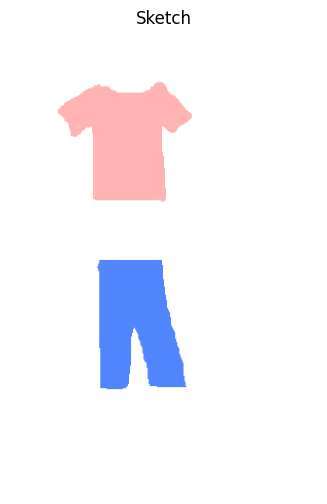

In [ ]:
sketch_image = Image.open('my_sketch.png')
display_images(sketch_image, 'Sketch')

## Step 5: Convert sketch to photo with Gemini 2.0 Flash

Pass the input sketch image and the artistic style as part of the prompt to Gemini 2.0 Flash Image Generation model.

>**Note:** To achieve the best possible painting from your sketch, aim to include ample detail. Using distinct colors for different elements or features in your sketch can provide clearer guidance to the model.

In [ ]:
input_image = 'my_sketch.png' # @param {type : 'string'}

prompt = "Convert this input sketch of an outfit into a catalogue photograph that shows a beautiful woman model wearing it." # @param {type : 'string'}

img = Image.open(input_image)

# Run model.
response = image_client.models.generate_content(
    model=MODEL_ID,
    contents=[prompt, img],
    config=types.GenerateContentConfig(
        temperature=0.5,
        safety_settings=safety_settings,
        response_modalities=['TEXT', 'IMAGE']
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    print(part.text)
  elif part.inline_data is not None:
    image = Image.open(BytesIO(part.inline_data.data))
    image.save('generated_image.png')

I will generate a catalogue photograph of a beautiful woman model wearing a light pink short-sleeved t-shirt and blue jeans. The photo will be well-lit and focused on the outfit, suitable for a fashion catalogue.



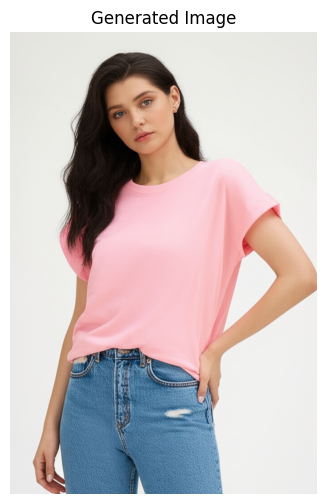

In [ ]:
output_image = Image.open('generated_image.png')
display_images(output_image, 'Generated Image')

## Step 6: Edit the photo with Gemini 2.0 Flash

In [ ]:
input_edit_image = 'generated_image.png' # @param {type : 'string'}

edit_prompt = "Add a white bead necklace" # @param {type : 'string'}

img = Image.open(input_edit_image)

# Run model.
response = image_client.models.generate_content(
    model=MODEL_ID,
    contents=[edit_prompt, img],
    config=types.GenerateContentConfig(
        temperature=0.5,
        safety_settings=safety_settings,
        response_modalities=['TEXT', 'IMAGE']
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    print(part.text)
  elif part.inline_data is not None:
    image = Image.open(BytesIO(part.inline_data.data))
    image.save('edited_image.png')

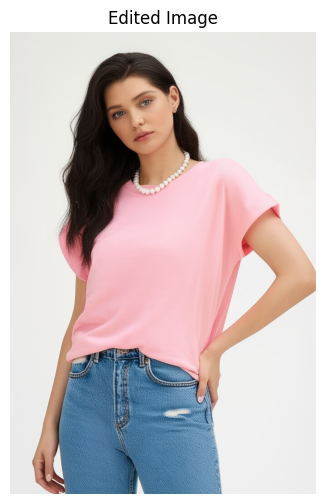

In [ ]:
output_edited_image = Image.open('edited_image.png')
display_images(output_edited_image, 'Edited Image')

## Step 7: Upload the final image to GCS bucket

In [ ]:
now = datetime.datetime.now()
datetime_str = now.strftime("%Y-%m-%d_%H-%M-%S")

# Upload the image on GCS bucket
GCS_BUCKET = userdata.get('GCS_BUCKET')
storage_client = storage.Client()

bucket = storage_client.bucket(GCS_BUCKET)
local_file_name = 'edited_image.png'
# Define the destination upload it to a folder 'images/' and file name
destination_blob_name_with_datetime = f'images/{datetime_str}_edited_image.png'

blob = bucket.blob(destination_blob_name_with_datetime)
blob.upload_from_filename(local_file_name)
print("Image uploaded on GCS bucket.")

Image uploaded on GCS bucket.


## Step 8: Generate a video from the edited image with Veo 3

In [ ]:
PROJECT_ID = userdata.get('GCP_PROJECT_ID')
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

video_client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)
video_model = "veo-3.0-generate-preview"

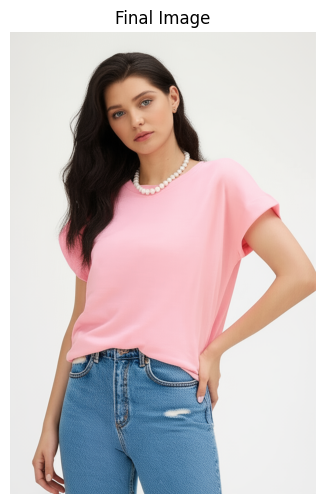

In [ ]:
image_show = Image.open('edited_image.png')
display_images(image_show, 'Final Image')

In [ ]:
prompt = "The fashion model walks toward the camera with a smile."  # @param {type: 'string'}

image_gcs = (
    f"gs://{GCS_BUCKET}/{destination_blob_name_with_datetime}"
)
output_gcs = f"gs://{GCS_BUCKET}/videos"
enhance_prompt = True  # @param {type: 'boolean'}
generate_audio = True  # @param {type: 'boolean'}


operation = video_client.models.generate_videos(
    model=video_model,
    prompt=prompt,
    image=types.Image(
        gcs_uri=image_gcs,
        mime_type="image/png",
    ),
    config=types.GenerateVideosConfig(
        aspect_ratio="16:9",
        output_gcs_uri=output_gcs,
        number_of_videos=1,
        duration_seconds=8,
        person_generation="allow_adult",
        enhance_prompt=enhance_prompt,
        generate_audio=generate_audio,
    ),
)

while not operation.done:
    operation = video_client.operations.get(operation)
    time.sleep(6)
    print(operation)

In [ ]:
if operation.response:
    show_video(operation.result.generated_videos[0].video.uri)

Copying gs://veo3-vertexai-demo/videos/17550044417736965472/sample_0.mp4...
/ [1 files][  1.9 MiB/  1.9 MiB]                                                
Operation completed over 1 objects/1.9 MiB.                                      


Congratulations on completing this tutorial and transforming your fashion sketches into runway videos using Gemini 2.0 Flash and Veo 3.